In [16]:
import pandas as pd
import plotnine as pn

In [17]:
# Constants for paper
params = [
    0, 1, 2, 4, 8, 16,
]

In [18]:
# Filepaths

#############################################################################
# Analysis files
#############################################################################

# Pareto frontier
curve_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/curve_points.csv"

# Pareto frontier
sampled_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/sampled_points.csv"

# Counterpart points
counterpart_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/counterpart_points.csv"

# Counterpart trajectories
counterpart_traj_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion=squared_dist/counterpart_trajectories.csv"

#############################################################################
# Simulation points
#############################################################################

# Reinforcement learning path
rl_fns = {
    f"{float(param)}":f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion=squared_dist/similarity=nosofsky_normed/dynamics=reinforcement_learning/num_trials=100/sim_param={param}/simulation_points.csv"
    for param in params
}

rl_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in rl_fns.items()
}

# Replicator dynamic path
rep_fns = {
    key: value.replace("reinforcement_learning", "replicator_dynamic") for key, value in rl_fns.items()
}

rep_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in rep_fns.items()
}

In [19]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
sampled_data = pd.read_csv(sampled_fn)
counterpart_final_data = pd.read_csv(counterpart_fn)
counterpart_traj_data = pd.read_csv(counterpart_traj_fn)

rl_sim_dfs = {k: pd.read_csv(rl_fns[k]) for k in rl_fns}
rl_trajs_dfs = {k: pd.read_csv(rl_traj_fns[k]) for k in rl_traj_fns}

rep_sim_dfs = {k: pd.read_csv(rep_fns[k]) for k in rep_fns}
rep_trajs_dfs = {k: pd.read_csv(rep_traj_fns[k]) for k in rep_traj_fns}

In [20]:
# label each df to be concatenated with a columns
def concat_with_columns(dfs: dict[str, pd.DataFrame], point_type: str, dynamic: str) -> pd.DataFrame:
    # add alpha for each dataframe
    for key in dfs:
        df = dfs[key]
        df["alpha"] = key # use string for category

    df = pd.concat(dfs.values())

    # annotate simulation-level info
    df["point_type"] = point_type
    df["dynamic"] = dynamic
    return df


# handle counterpart differently

counterpart_final_data["point_type"] = "single_trial"
counterpart_traj_data["point_type"] = "trajectory"
counterpart_final_data["dynamic"] = "blahut_arimoto"
counterpart_traj_data["dynamic"] = "blahut_arimoto"

concat_with_columns_rl = lambda dfs, point_type: concat_with_columns(dfs, point_type, "reinforcement_learning")

rl_sim_data = concat_with_columns_rl(rl_sim_dfs, "single_trial")
rl_traj_data = concat_with_columns_rl(rl_trajs_dfs, "trajectory")

concat_with_columns_rd = lambda dfs, point_type: concat_with_columns(dfs, point_type, "replicator_dynamic")

rep_sim_data = concat_with_columns_rd(rep_sim_dfs, "single_trial")
rep_traj_data = concat_with_columns_rd(rep_trajs_dfs, "trajectory")

# annotate sampled data
sampled_data["dynamic"] = "sampling"

In [21]:
# concatenate all simulation-related (e.g. NOT sampled) data into one dataframe
data = pd.concat([
    counterpart_final_data,
    counterpart_traj_data,
    rl_sim_data, 
    rl_traj_data,
    rep_sim_data, 
    rep_traj_data,
]).reset_index()
data

,index,rate,distortion,beta,alpha,point_type,dynamic,round
0,0,3.321928,0.000000,1000.000000,0.0,single_trial,blahut_arimoto,NaN
1,1,1.861867,0.485263,1.000000,1.0,single_trial,blahut_arimoto,NaN
2,2,0.963131,1.822883,0.250000,2.0,single_trial,blahut_arimoto,NaN
3,3,0.057531,7.616357,0.062500,4.0,single_trial,blahut_arimoto,NaN
4,4,0.001560,8.380513,0.015625,8.0,single_trial,blahut_arimoto,NaN
...,...,...,...,...,...,...,...,...
603601,195,0.139133,13.659197,NaN,16.0,trajectory,replicator_dynamic,195.0
603602,196,0.139536,13.653757,NaN,16.0,trajectory,replicator_dynamic,196.0
603603,197,0.139996,13.646922,NaN,16.0,trajectory,replicator_dynamic,197.0
603604,198,0.140527,13.638540,NaN,16.0,trajectory,replicator_dynamic,198.0


## Generate plot for points and trajectories, for each dynamic

In [22]:
# let alpha just be integer valued (and then string valued for categorical var)
data["alpha"] = data["alpha"].astype(float)
data["alpha"] = data["alpha"].astype(int)
data["alpha"] = data["alpha"].astype(str)

data = data.assign(
    alpha=pd.Categorical(
        data["alpha"],
        categories=[str(param) for param in params]
    )
)
data # N.B.: nans are expected for 'round' column

,index,rate,distortion,beta,alpha,point_type,dynamic,round
0,0,3.321928,0.000000,1000.000000,0,single_trial,blahut_arimoto,NaN
1,1,1.861867,0.485263,1.000000,1,single_trial,blahut_arimoto,NaN
2,2,0.963131,1.822883,0.250000,2,single_trial,blahut_arimoto,NaN
3,3,0.057531,7.616357,0.062500,4,single_trial,blahut_arimoto,NaN
4,4,0.001560,8.380513,0.015625,8,single_trial,blahut_arimoto,NaN
...,...,...,...,...,...,...,...,...
603601,195,0.139133,13.659197,NaN,16,trajectory,replicator_dynamic,195.0
603602,196,0.139536,13.653757,NaN,16,trajectory,replicator_dynamic,196.0
603603,197,0.139996,13.646922,NaN,16,trajectory,replicator_dynamic,197.0
603604,198,0.140527,13.638540,NaN,16,trajectory,replicator_dynamic,198.0


In [23]:
# now concat sampled data 
data = pd.concat([data, sampled_data])
data

,index,rate,distortion,beta,alpha,point_type,dynamic,round
0,0.0,3.321928,0.000000,1000.000000,0,single_trial,blahut_arimoto,NaN
1,1.0,1.861867,0.485263,1.000000,1,single_trial,blahut_arimoto,NaN
2,2.0,0.963131,1.822883,0.250000,2,single_trial,blahut_arimoto,NaN
3,3.0,0.057531,7.616357,0.062500,4,single_trial,blahut_arimoto,NaN
4,4.0,0.001560,8.380513,0.015625,8,single_trial,blahut_arimoto,NaN
...,...,...,...,...,...,...,...,...
177240,NaN,0.170945,8.947140,NaN,NaN,NaN,sampling,NaN
177241,NaN,1.986940,6.225000,NaN,NaN,NaN,sampling,NaN
177242,NaN,1.986940,6.225000,NaN,NaN,NaN,sampling,NaN
177243,NaN,0.138935,9.544770,NaN,NaN,NaN,sampling,NaN


In [24]:
rep_points = data[data["dynamic"] == "replicator_dynamic"]
rep_emergent = rep_points[rep_points["point_type"] == "single_trial"]

rl_points = data[data["dynamic"] == "reinforcement_learning"]
rl_emergent = rl_points[rl_points["point_type"] == "single_trial"]

rep_emergent["language"] = "evolved"
rl_emergent["language"] = "learned"

sampled_points = data[data["dynamic"] == "sampling"]
sampled_points["language"] = "hypothetical"

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/3154003436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/3154003436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/3154003436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [25]:
# extract the trajectory data
rep_trajs = rep_points[rep_points["point_type"] == "trajectory"]
rl_trajs = rl_points[rl_points["point_type"] == "trajectory"]

# including 'counterparts' from B-A optimization
counterpart_data = data[data["dynamic"] == "blahut_arimoto"]
# set the language column for counterparts
counterpart_data["language"] = "optimal \ncounterpart"
counterpart_points = counterpart_data[counterpart_data["point_type"] == "single_trial"]
counterpart_trajs = counterpart_data[counterpart_data["point_type"] == "trajectory"]

# set the final rounds
rep_final_round_data = rep_trajs[rep_trajs["round"] == rep_trajs["round"].max()]
rl_final_round_data = rl_trajs[rl_trajs["round"] == rl_trajs["round"].max()]
counterpart_final_round_data = counterpart_trajs[counterpart_trajs["round"] == counterpart_trajs["round"].max()]

rep_final_round_data["language"] = "evolved"
rl_final_round_data["language"] = "learned"

display(rl_trajs)
display(rep_final_round_data)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/2693434271.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/2693434271.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/2693434271.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,index,rate,distortion,beta,alpha,point_type,dynamic,round
1806,0.0,0.007064,16.443802,NaN,0,trajectory,reinforcement_learning,0.0
1807,1.0,0.007166,16.439747,NaN,0,trajectory,reinforcement_learning,1.0
1808,2.0,0.007261,16.431988,NaN,0,trajectory,reinforcement_learning,2.0
1809,3.0,0.007324,16.433375,NaN,0,trajectory,reinforcement_learning,3.0
1810,4.0,0.007445,16.423548,NaN,0,trajectory,reinforcement_learning,4.0
...,...,...,...,...,...,...,...,...
601801,99995.0,0.017970,15.072813,NaN,16,trajectory,reinforcement_learning,99995.0
601802,99996.0,0.017970,15.072801,NaN,16,trajectory,reinforcement_learning,99996.0
601803,99997.0,0.017970,15.072791,NaN,16,trajectory,reinforcement_learning,99997.0
601804,99998.0,0.017970,15.072789,NaN,16,trajectory,reinforcement_learning,99998.0


,index,rate,distortion,beta,alpha,point_type,dynamic,round,language
602605,199.0,3.081134,1.724890,NaN,0,trajectory,replicator_dynamic,199.0,evolved
602805,199.0,2.713356,0.368738,NaN,1,trajectory,replicator_dynamic,199.0,evolved
603005,199.0,1.835892,1.129012,NaN,2,trajectory,replicator_dynamic,199.0,evolved
603205,199.0,1.189177,4.232014,NaN,4,trajectory,replicator_dynamic,199.0,evolved
603405,199.0,0.528926,12.670285,NaN,8,trajectory,replicator_dynamic,199.0,evolved
603605,199.0,0.141133,13.628781,NaN,16,trajectory,replicator_dynamic,199.0,evolved


In [26]:
# Define a float-valued column in data to get color scale, called "imprecision"

rl_emergent["imprecision"] = rl_emergent["alpha"]
rep_emergent["imprecision"] = rep_emergent["alpha"]
rl_trajs["imprecision"] = rl_trajs["alpha"]
rep_trajs["imprecision"] = rep_trajs["alpha"]
rl_final_round_data["imprecision"] = rl_final_round_data["alpha"]
rep_final_round_data["imprecision"] = rep_final_round_data["alpha"]
counterpart_points["imprecision"] = counterpart_points["alpha"]

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/2800178743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/2800178743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_7401/2800178743.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

### Discrete-Time Replicator Dynamic

#### Points

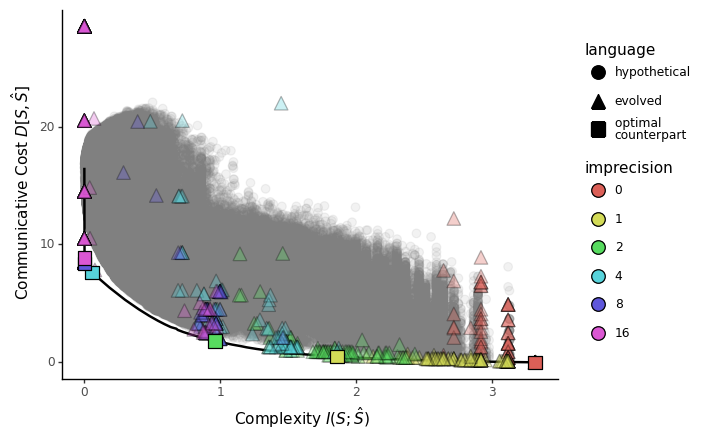

In [27]:
plot_rep = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # hypothetical langs
        data=sampled_points,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(size=1) # pareto data                   
    + pn.geom_jitter( # emergent langs
        data=rep_emergent,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        alpha=0.3,
        size=5,
    )
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_points,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        size=5,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    # + pn.ggtitle("Discrete-time Replicator Dynamic")
    + pn.theme_classic()
)
print(plot_rep)

#### Trajectories

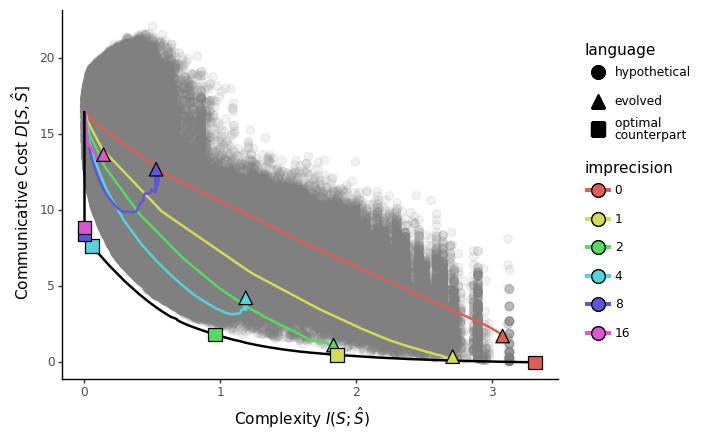

In [28]:
plot_rep_traj = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(
        data=sampled_points,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(  # simulation langs
        data=rep_trajs,
        mapping=pn.aes(color="imprecision"),
        alpha=1.0,
        size=1,
    )
    + pn.geom_line(size=1) # pareto     
    + pn.geom_point(  # final langs
        data=rep_final_round_data,
        mapping=pn.aes(fill="imprecision", shape="language"),
        # shape="X",
        size=5,
    ) 
    + pn.geom_point( # theoretical bound langs
        data=counterpart_points,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        size=5,
    )               
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
    + pn.theme_classic()
)
print(plot_rep_traj)

### Roth-Erev learning

#### Points

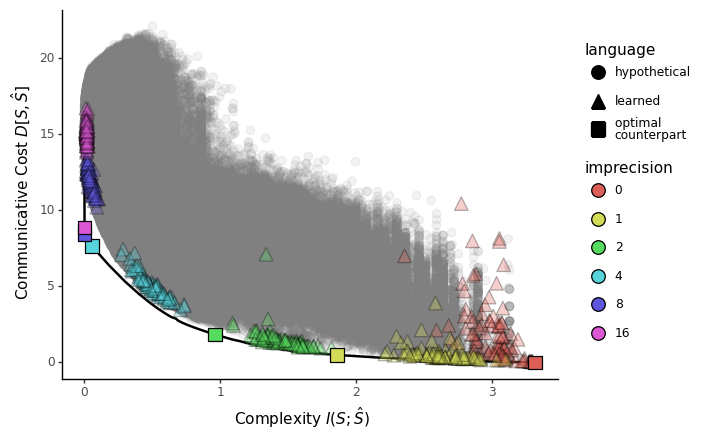

In [29]:
plot_rl = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # hypothetical langs
        data=sampled_points,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(size=1) # pareto data                   
    + pn.geom_jitter( # emergent
        data=rl_emergent,
        mapping=pn.aes(
            fill="imprecision",
            shape="language", 
            ),
        alpha=0.3,
        size=5,
    )
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_points,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        size=5,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")    
    + pn.theme_classic()    
)
print(plot_rl)

#### Trajectories

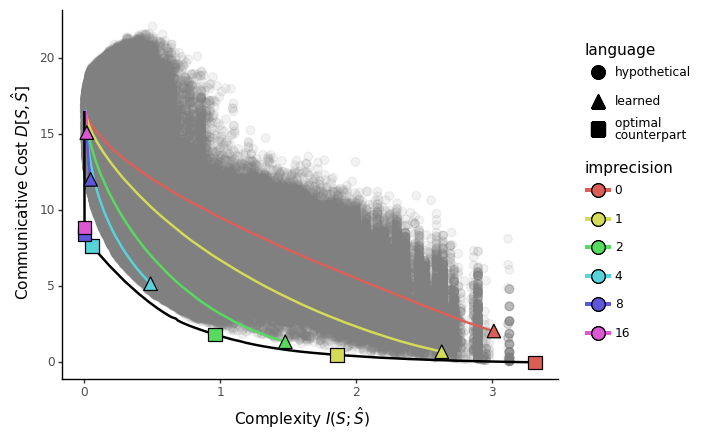

In [30]:
plot_rl_traj = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point( 
        data=sampled_points,
        mapping=pn.aes(shape="language"),
        color="gray",
        size=3,
        alpha=0.1,
    )
    + pn.geom_line(  # simulation langs
        data=rl_trajs,
        mapping=pn.aes(color="imprecision"),
        alpha=1.0,
        size=1,
    )
    + pn.geom_line(size=1) # pareto
    + pn.geom_point(  # final langs
        data=rl_final_round_data,
        mapping=pn.aes(fill="imprecision", shape="language"),
        size=5,
    )
    + pn.geom_point( # theoretical bound langs
        data=counterpart_points,
        mapping=pn.aes(
            fill="imprecision",
            shape="language",
            ),
        size=5,
    )
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")        
    + pn.theme_classic()
)
print(plot_rl_traj)

#### Save plots

In [32]:
def save_plot(fn: str, plot: pn.ggplot, width=10, height=10, dpi=300) -> None:
    """Save a plot with some default settings."""
    plot.save(fn, width=10, height=10, dpi=300)

save_plot("rep_main", plot_rep)
save_plot("rep_traj", plot_rep_traj)
save_plot("rl_main", plot_rl)
save_plot("rl_traj", plot_rl_traj)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: rep_main
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: rep_traj
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: rl_main
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/sit